In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# matplotlib style
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-notebook')

In [99]:
# load train data to build model
df_initial = pd.read_csv('data/data_initial.csv')
print(df_initial.dtypes)
df = pd.read_csv('data/train.csv')
df = df.drop(columns='type')

df.dtypes



category                 object
rating                  float64
reviews                   int64
installs                  int64
type                     object
price                   float64
content_rating           object
app_size                float64
last_updated_encoded      int64
dtype: object


category                 object
rating                  float64
reviews                 float64
installs                float64
price                   float64
content_rating           object
app_size                float64
last_updated_encoded      int64
dtype: object

# Data Exploration
* Categorical, bar charts - Amee 
* Histograms - Flora
* Scatter plots matrix of all numeric variables - Sandy
* Correlation analysis for numeric variables (heatmap)  - Sandy 


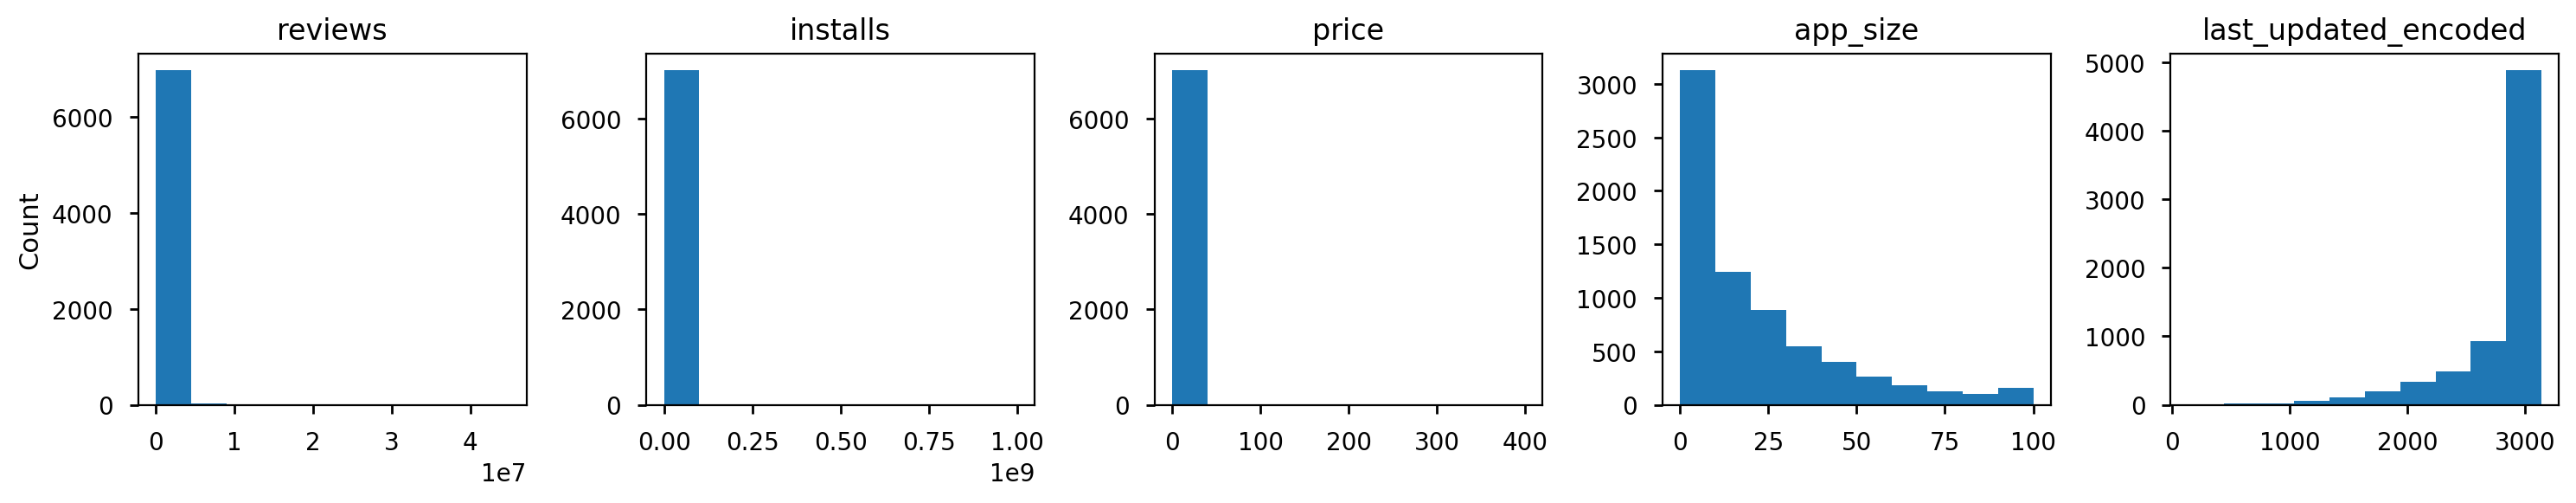

In [100]:
# numeric variables
numeric_vars = df_initial.select_dtypes(np.number)
x_numeric_vars = numeric_vars.drop(columns='rating')
fig, axes = plt.subplots(nrows=1, ncols=len(x_numeric_vars.columns), figsize = (15,3) )
axes = np.array(axes).flatten()

for i, ax in enumerate(axes):
    data = x_numeric_vars
    ax.hist(data.iloc[:, i])
    ax.set_title(data.columns[i])
axes[0].set_ylabel('Count')
    
plt.tight_layout()
plt.show()

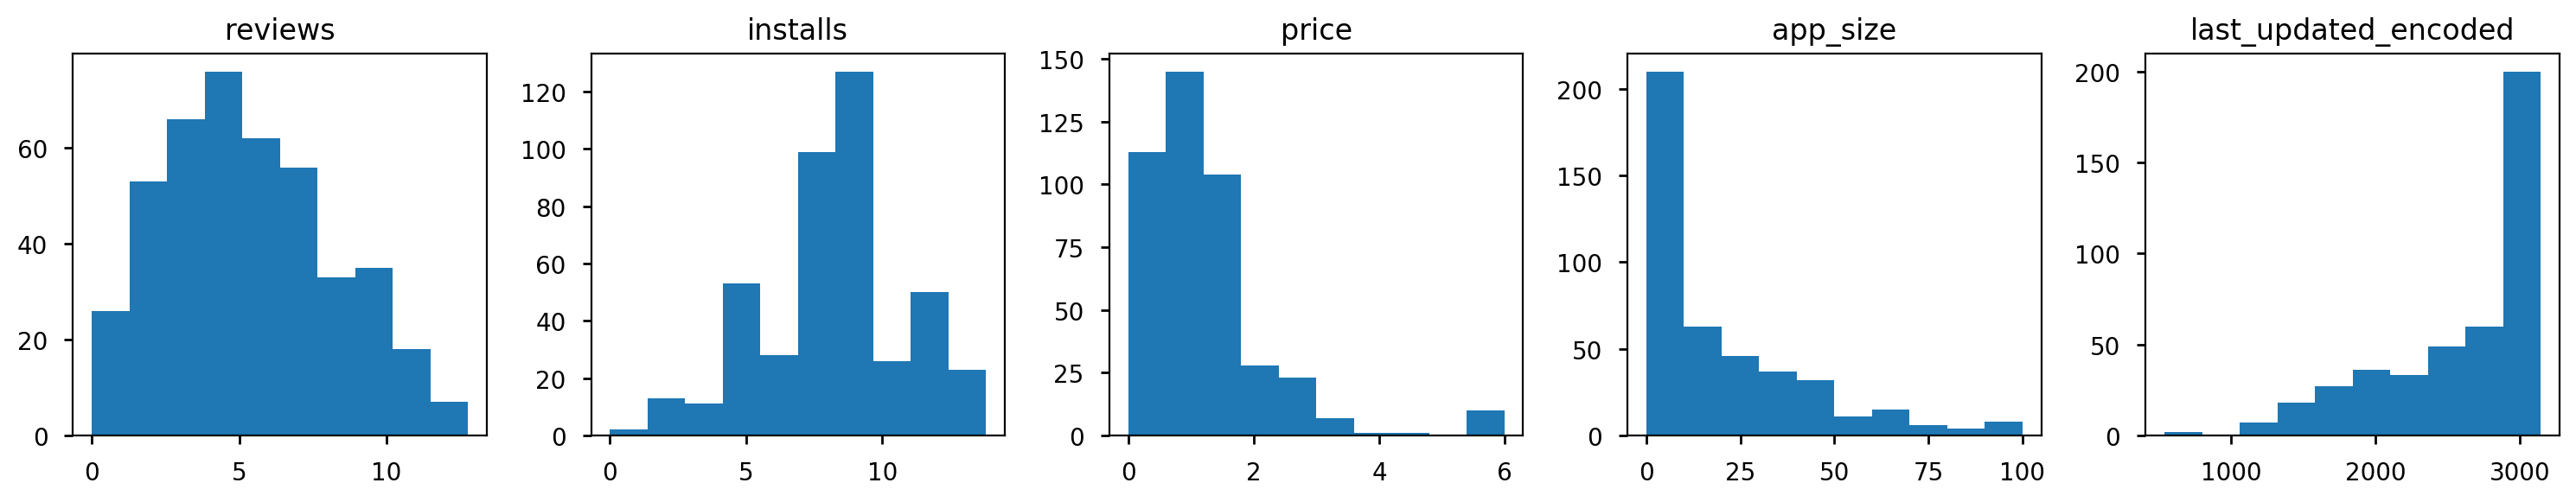

In [101]:
# numeric variables
numeric_vars = df.select_dtypes(np.number)
x_numeric_vars = numeric_vars.drop(columns='rating')

fig, axes = plt.subplots(nrows=1, ncols=len(x_numeric_vars.columns), figsize = (15,3) )
axes = np.array(axes).flatten()

for i, ax in enumerate(axes):
    data = x_numeric_vars
    ax.hist(data.iloc[:, i])
    ax.set_title(data.columns[i])
    
plt.tight_layout()
plt.show()

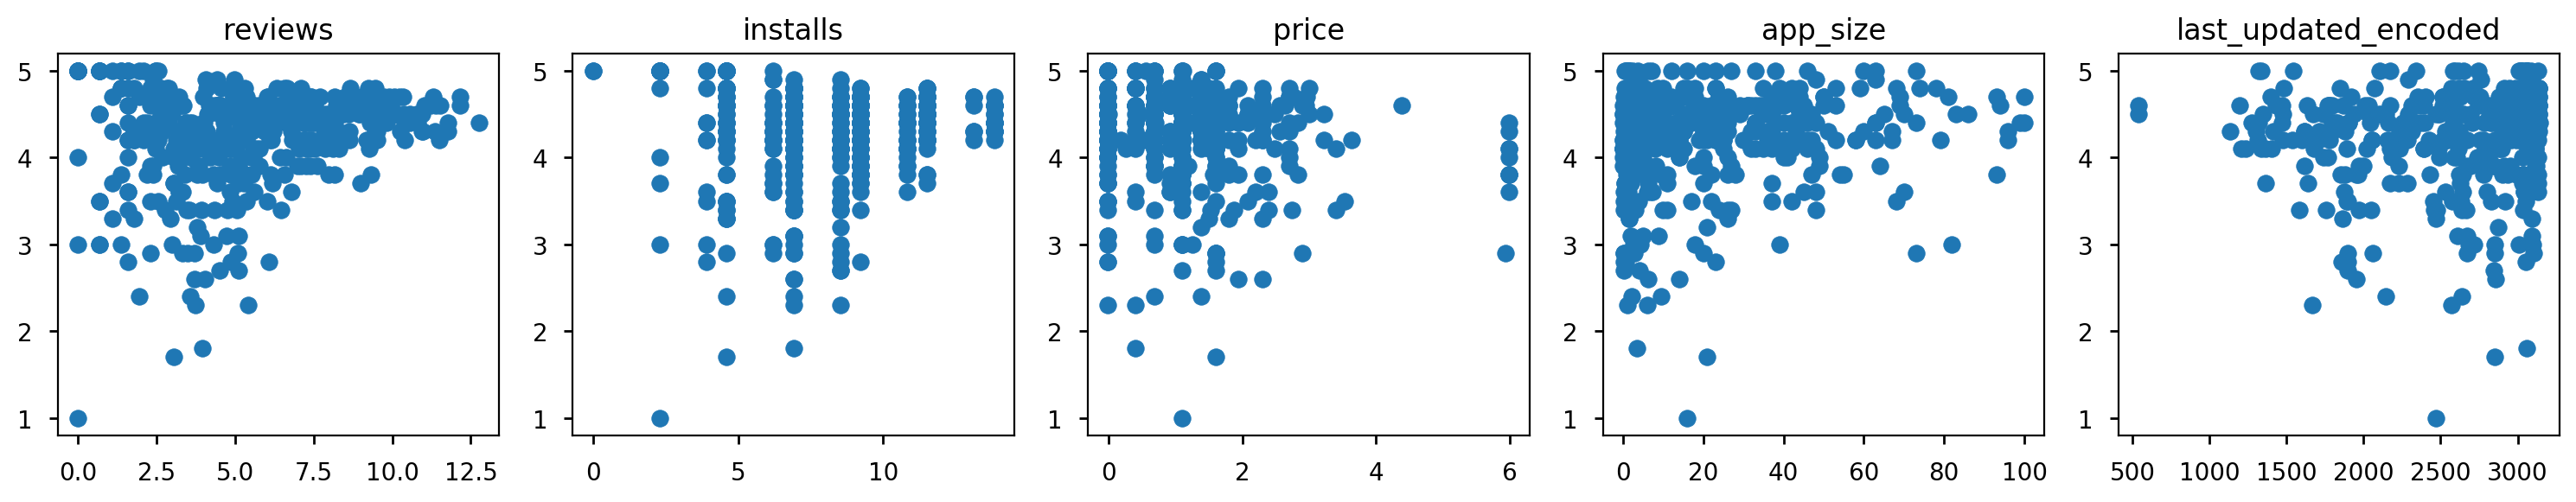

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=len(x_numeric_vars.columns),  figsize = (15,3)  )
axes = np.array(axes).flatten()

for i, ax in enumerate(axes):
    data = x_numeric_vars
    ax.scatter(x_numeric_vars.iloc[:, i],df.rating)
    ax.set_title(x_numeric_vars.columns[i])
    
plt.tight_layout()
plt.show()

### It appears that reviews, installs, price have large range, obscuring the direct histogram view

# Initial model fit with all variables

In [ ]:
# regress rating against all other variables
ystr = 'rating'
x_var = [col for col in df.columns if col != ystr]
xstr = '+'.join(x_var)

# build initial ols model 
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()

# drop a variable in model 
x_var2 = x_var.copy()
x_var2.remove(set(x_var2).pop())
xstr_drop = '+'.join(x_var2)
model_drop = smf.ols(f'{ystr}~{xstr_drop}', data=df).fit()

print(model.summary())
# print(model_drop.summary())


# ANOVA

In [ ]:
partial = sa.anova_lm(model, type=2)
partial_drop = sa.anova_lm(model_drop, type=2)
seq = sa.anova_lm(model, type=1)
seq_drop = sa.anova_lm(model_drop, type=1)

print('~~~~~~~ Partial ANOVA ~~~~~~~')
print(partial)

print('\n~~~~~~~ Partial ANOVA w/ one dropped variable~~~~~~~')
print(partial_drop)

# print('\n~~~~~~~ Sequential ANOVA ~~~~~~~')
# print(seq)

# print('\n~~~~~~~ Sequential ANOVA w/ one dropped variable ~~~~~~~')
# print(seq_drop)


## Multicolinearity

In [ ]:
numeric_x_var = df[x_var].select_dtypes(np.number)
X = sm.add_constant(numeric_x_var)
vif = pd.DataFrame([variance_inflation_factor(X.values, i) \
                    for i in range(X.shape[1])], 
                   index=['intercept'] + list(X.columns[1:].str.lower()),
                   columns=['vif'])
print(vif)

# Best subsets adhj-R, Cp, AIC/BIC

In [ ]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dummy2cat(vars):
    output = []
    cat = 0
    type_var = 0
    content = 0
    for var in vars:
        if any([cat_var in var for cat_var in ['category','content_rating', 'type']]):
            if cat == 0:
                output.append('category')
                cat = 1
            elif type_var == 0:
                output.append('type')
                type_var = 1
            elif content == 0:
                output.append('content')
                content = 1
        else:
            output.append(var)
    return var
            
subsets = list(powerset(x_var))[1:]
subsets_ols = [f"{ystr}~{'+'.join(sub)}" for sub in subsets]
models = [smf.ols(sub, data=df).fit() for sub in subsets_ols]


full_mse = models[-1].mse_resid
mallow = lambda reduced:  np.sum(np.power(reduced.resid, 2)) / full_mse - (len(df) - 2*len(reduced.params))
stat = [np.array([model.rsquared_adj, mallow(model)]) for model in models]

In [ ]:
# rsqr mallow
rcp = []
for i, (r, mcp) in enumerate(stat):
    var_nums = len(models[i].params)-1
    predictors = ", ".join(subsets[i])
    rcp.append([var_nums, predictors, r, mcp])

rcp_df = pd.DataFrame(data=rcp, columns=['Vars', 'Predictors','Adjusted R-sqr', 'Mallow Cp'])


plt.scatter(rcp_df.Vars, rcp_df['Mallow Cp'], )
plt.plot(rcp_df.Vars,rcp_df.Vars)

plt.show()

rcp_df[rcp_df['Mallow Cp'] == min(rcp_df['Mallow Cp'])].Predictors.values


### aic bic
aicbic=[]
ic_vals = [(model.aic, model.bic) for model in models]
for i, (aic, bic) in enumerate(ic_vals):
    var_nums = len(models[i].params)-1
    predictors = ", ".join(subsets[i])
    aicbic.append([var_nums, predictors, aic, bic])
    
aicbic_df = pd.DataFrame(data=aicbic, columns=['Vars', 'Predictors','aic', 'bic'])

fig, ax = plt.subplots(1,2,)

ax[0].scatter(aicbic_df.Vars, aicbic_df['aic'])
ax[0].set_title('AIC')
ax[1].scatter(aicbic_df.Vars, aicbic_df['bic'])
ax[1].set_title('BIC')

plt.show()

In [ ]:
best = 'category, reviews, installs, price, last_updated_encoded'.split(',')
ystr = 'rating'
x_var = best
xstr = '+'.join(x_var)

# build initial ols model 
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()

# drop a variable in model 
x_var2 = x_var.copy()
x_var2.remove(set(x_var2).pop())
xstr_drop = '+'.join(x_var2)
model_drop = smf.ols(f'{ystr}~{xstr_drop}', data=df).fit()

print(model.summary())